In [2]:
import xarray as xr
import random
import glob
import numpy as np
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import dask
import matplotlib.pyplot as plt

/lus/scratch/shao/miniconda3/envs/analysis/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
# Use Distributed dask if available
cluster = SLURMCluster(
    cores = 48,
    memory = '192GB',
    processes=1,
    walltime='12:00:00'
)
cluster.scale(jobs=6)
client = Client(cluster)

In [2]:
# Set other dask-related improvements
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [19]:
datapath = '/lus/scratch/shao/data/NEP36_extremes/processed/3hr'
ds = xr.open_dataset(f'{datapath}/2007.nc',chunks='auto')

In [20]:
resample_frequencies = [
    '6h',
    '12h',
    '1D',
    '5D',
]

ds_resample = {}
hist_resample = {}

ds_resample['3h'] = ds

for resample_frequency in resample_frequencies:
    ds_resample[resample_frequency] = ds.resample(time=resample_frequency).mean(dim='time')

In [21]:
base_frequency = '3h'
nbins = 50

plot_variables = [
    'O2',
    'DIC',
    'T'
]

def flatten_and_drop_nan( da ):
    """
    Flatten an xarray DataArray, convert to a 1D numpy, and drop all NaNs
    """
    array = da.to_numpy().flatten()
    array = array[np.isfinite(array)]
    array = array[ array != 0. ]
    return array

var_hist = {}
var_bin_edges = {}

for var in plot_variables:
    var_hist[var] = {}
    hist, bin_edges = np.histogram(
        flatten_and_drop_nan(ds_resample[base_frequency][var]),
        nbins,
        density=True
    )
    var_hist[var]['3h'] = hist.copy()
    var_bin_edges[var] = bin_edges
    for resample_frequency in resample_frequencies:
        print(f'Processing {var} at {resample_frequency}')
        hist, _ = np.histogram(
            flatten_and_drop_nan(ds_resample[resample_frequency][var]),
            bin_edges,
            density=True
        )
        var_hist[var][resample_frequency] = hist.copy()


Processing O2 at 6h
Processing O2 at 12h
Processing O2 at 1D
Processing O2 at 5D
Processing DIC at 6h
Processing DIC at 12h
Processing DIC at 1D
Processing DIC at 5D
Processing T at 6h
Processing T at 12h
Processing T at 1D
Processing T at 5D


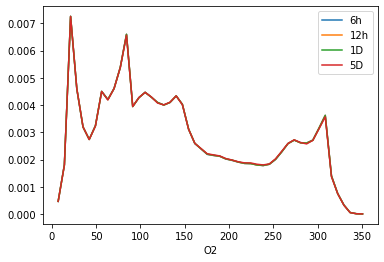

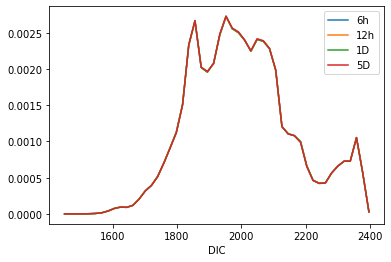

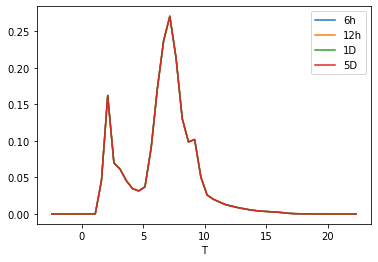

In [22]:
for var in plot_variables:
    plt.figure()
    for resample_frequency in resample_frequencies:
        plt.plot(var_bin_edges[var][1:], var_hist[var][resample_frequency], label=resample_frequency)
    plt.xlabel(f'{var}')
    plt.legend()